In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from nilearn import image
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix, plot_stat_map
from nilearn.interfaces.fmriprep import load_confounds
sys.path.append('..')
from utils.data import Subject, load_participant_list
from utils.analysis import compute_parametric_modulator

In [3]:
base_dir = '/Users/hugofluhr/data/LH_dev'
bids_dir = "/Users/hugofluhr/data/LH_dev/fmriprep-23.2.1"

sub_ids = load_participant_list(base_dir)

In [4]:
#subjects = [Subject(base_dir, sub_id, include_modeling=True, include_imaging=True, bids_dir=bids_dir) for sub_id in sub_ids]
subject = Subject(base_dir, '01', include_modeling=True, include_imaging=True, bids_dir=bids_dir)

# Setting parameters

In [5]:
tr = 2.33384
hrf_model = 'spm'
noise_model = 'ar1'
smoothing_fwhm = 5
high_pass = 0.01
motion_type = 'full'

run = 'learning1'
# ref to the block
block = getattr(subject, run)

# Get the data

In [6]:
np.corrcoef(block.extended_trials.first_stim_value_rl, block.extended_trials.first_stim_value_ck)[1, 0]

0.5804749453324884

In [7]:
events = block.extend_events_df()
events.head(5)

,onset,duration,trial_type,trial,first_stim_value_rl,first_stim_value_ck
0,0.009399,0.817157,first_stim_presentation,1,1.830729,0.0
1,0.826556,0.934432,second_stim_presentation,1,0.000000,0.0
2,1.760988,0.000000,response,1,0.000000,0.0
3,1.766016,1.569584,purple_frame,1,0.000000,0.0
4,2.268539,1.067061,points_feedback,1,0.000000,0.0


In [8]:
img_path = subject.img.get(run)
fmri_img = image.load_img(img_path)

In [9]:
confounds, sample_mask  = subject.load_confounds(run, motion_type=motion_type)

In [10]:
confounds.head(2)

,csf,rot_x,rot_x_derivative1,rot_x_derivative1_power2,rot_x_power2,rot_y,rot_y_derivative1,rot_y_derivative1_power2,rot_y_power2,rot_z,...,trans_z,trans_z_derivative1,trans_z_derivative1_power2,trans_z_power2,white_matter,cosine00,cosine01,cosine02,cosine03,cosine04
0,27.856635,-0.006275,0.001474,0.000001,9.795965e-07,-0.001482,0.000339,1.561292e-08,5.056087e-07,-0.001769,...,0.197327,0.037695,-0.00052,-0.109757,8.010894,0.070067,0.069900,0.069988,0.069599,0.069176
1,-6.503313,-0.004784,0.001474,0.000001,-8.256492e-06,-0.001140,0.000339,1.561292e-08,-2.012586e-07,-0.001838,...,0.234554,0.037695,-0.00052,-0.111133,3.195605,0.070064,0.069885,0.069955,0.069539,0.069082


# No parametric modulation

In [11]:
n = fmri_img.shape[-1]
frametimes = np.linspace(tr/2., (n - .5)*tr, n) # from Gilles, checked with nilearn FirstLevelModel

In [12]:
X1 = make_first_level_design_matrix(frame_times=frametimes,
                                    events=events,
                                    hrf_model=hrf_model,
                                    drift_model=None,
                                    high_pass=high_pass,
                                    add_regs=confounds)

/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:142: UserWarning: The following conditions contain events with null duration:
response.
  warnings.warn(
/Users/hugofluhr/miniforge3/envs/neuroim/lib/python3.10/site-packages/nilearn/glm/first_level/experimental_paradigm.py:167: UserWarning: The following unexpected columns in events data will be ignored: first_stim_value_rl, trial, first_stim_value_ck
  warnings.warn(


In [13]:
model1 = FirstLevelModel(smoothing_fwhm=smoothing_fwhm)
model1 = model1.fit(fmri_img, design_matrices=X1, sample_masks=sample_mask)

# Plotting results

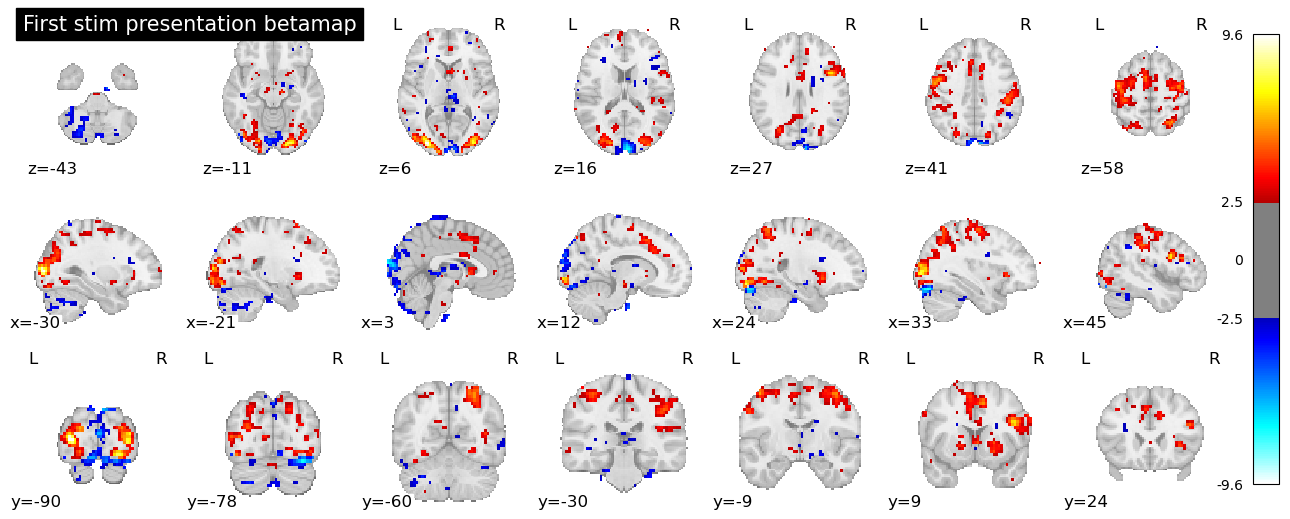

In [14]:
z_map1 = model1.compute_contrast(
    contrast_def="first_stim_presentation", output_type="z_score"
)

plot_stat_map(
    z_map1,
    threshold=2.5,
    display_mode="mosaic",
    title=f"First stim presentation betamap",
)

# Parametric modulation

In [15]:
condition = 'first_stim_presentation'

reg_rl_value = compute_parametric_modulator(events, condition, 'first_stim_value_rl',
                                            frametimes, hrf_model)
reg_ck_value = compute_parametric_modulator(events, condition, 'first_stim_value_ck',
                                            frametimes, hrf_model)

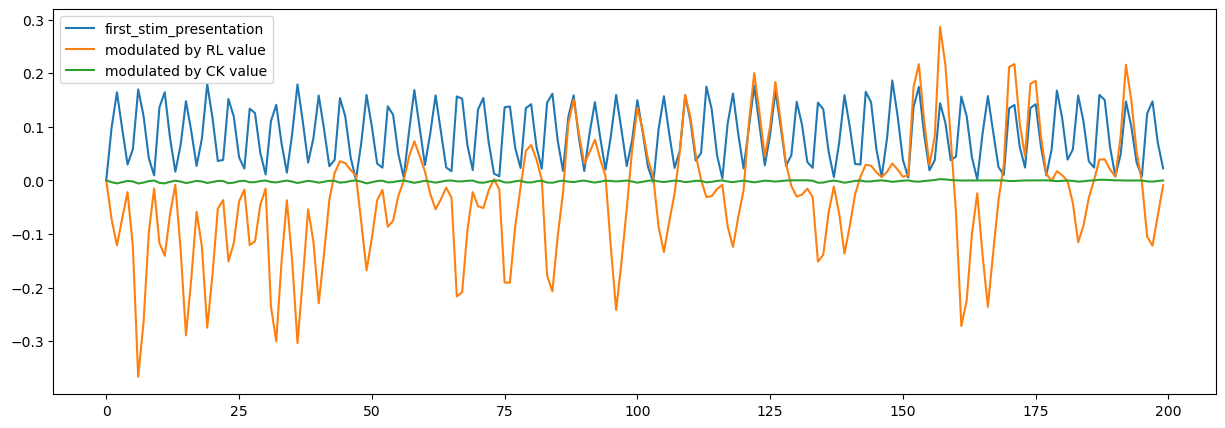

In [16]:
plt.figure(figsize=(15, 5))
plt.plot(X1[condition].values[:200], label=condition)
plt.plot(reg_rl_value[:200], label = 'modulated by RL value')
plt.plot(reg_ck_value[:200], label = 'modulated by CK value')
plt.legend()
plt.show()

In [17]:
X_complete = X1.copy()
X_complete.insert(1, 'first_stim_value_rl', reg_rl_value)
X_complete.insert(2, 'first_stim_value_ck', reg_ck_value)

In [18]:
model2 = FirstLevelModel(smoothing_fwhm=smoothing_fwhm, minimize_memory=False)#, mask_img=bartra_mask_path)
model2 = model2.fit(fmri_img, design_matrices=X_complete, sample_masks=sample_mask)

## Different model comparison

In [22]:
z_map_pres_2 = model2.compute_contrast(
    contrast_def="first_stim_presentation", output_type="z_score"
)
z_map_rl_2 = model2.compute_contrast(
    contrast_def="first_stim_value_rl", output_type="z_score"
)
z_map_ck_2 = model2.compute_contrast(
    contrast_def="first_stim_value_ck", output_type="z_score"
)

In [26]:
np.corrcoef(z_map1.get_fdata().ravel(), z_map_pres_2.get_fdata().ravel())[0,1]

0.9996238565278106

In [27]:
np.corrcoef(z_map_pres_2.get_fdata().ravel(), z_map_rl_2.get_fdata().ravel())[0,1]

0.030799025336513856

In [28]:
np.corrcoef(z_map_pres_2.get_fdata().ravel(), z_map_ck_2.get_fdata().ravel())[0,1]

-0.11696012405441954

In [30]:
np.corrcoef(z_map_rl_2.get_fdata().ravel(), z_map_ck_2.get_fdata().ravel())[0,1]

-0.6270477480273616

In [31]:
z_map_contrast_rl = model2.compute_contrast(
    contrast_def="first_stim_value_rl-first_stim_presentation", output_type="z_score"
)
z_map_contrast_ck = model2.compute_contrast(
    contrast_def="first_stim_value_ck-first_stim_presentation", output_type="z_score"
)

In [32]:
np.corrcoef(z_map_contrast_rl.get_fdata().ravel(), z_map_contrast_ck.get_fdata().ravel())[0,1]

0.12698574609074187

# Split modeling of the 2 modulators

In [33]:
# Build the design matrix
X_rl = X1.copy()
X_rl.insert(1, 'first_stim_value_rl', reg_rl_value)

# Fit the first-level model
modelRL = FirstLevelModel(smoothing_fwhm=smoothing_fwhm, minimize_memory=True)
modelRL = modelRL.fit(fmri_img, design_matrices=X_rl, sample_masks=sample_mask)

In [34]:
# Build the design matrix
X_ck = X1.copy()
X_ck.insert(1, 'first_stim_value_ck', reg_ck_value)

# Fit the first-level model
modelCK = FirstLevelModel(smoothing_fwhm=smoothing_fwhm, minimize_memory=True)
modelCK = modelCK.fit(fmri_img, design_matrices=X_ck, sample_masks=sample_mask)

In [35]:
z_map_pres_rl = modelRL.compute_contrast(
    contrast_def="first_stim_presentation", output_type="z_score"
)
z_map_pres_ck = modelCK.compute_contrast(
    contrast_def="first_stim_presentation", output_type="z_score"
)
z_map_rl_only = modelRL.compute_contrast(
    contrast_def="first_stim_value_rl", output_type="z_score"
)
z_map_ck_only = modelCK.compute_contrast(
    contrast_def="first_stim_value_ck", output_type="z_score"
)

In [36]:
np.corrcoef(z_map_pres_rl.get_fdata().ravel(), z_map_pres_2.get_fdata().ravel())[0,1]

0.9996980938288051

In [37]:
np.corrcoef(z_map_pres_rl.get_fdata().ravel(), z_map_pres_ck.get_fdata().ravel())[0,1]

0.9997878330322496

In [38]:
np.corrcoef(z_map_rl_only.get_fdata().ravel(), z_map_rl_2.get_fdata().ravel())[0,1]

0.7987720004696314

In [39]:
np.corrcoef(z_map_ck_only.get_fdata().ravel(), z_map_ck_2.get_fdata().ravel())[0,1]

0.8834869096806965

In [40]:
np.corrcoef(z_map_rl_only.get_fdata().ravel(), z_map_ck_only.get_fdata().ravel())[0,1]

0.4396436822860321

## Results of splitting models
Despite fitting models separately, the correlation between the beta maps of the RL and CK modulations remains really high, especially in the Test run

### Contrasts of split model

In [41]:
z_map_contrast_rl_only = modelRL.compute_contrast(
    contrast_def="first_stim_value_rl-first_stim_presentation", output_type="z_score"
)
z_map_contrast_ck_only = modelCK.compute_contrast(
    contrast_def="first_stim_value_ck-first_stim_presentation", output_type="z_score"
)

In [42]:
np.corrcoef(z_map_contrast_rl_only.get_fdata().ravel(), z_map_contrast_ck_only.get_fdata().ravel())[0,1]


0.28378508136098823